In [1]:
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [2]:
import numpy as np
import pandas as pd
import spacy

# Load the large model to get the vectors
nlp = spacy.load('en_core_web_lg')


# Loading new dataset

* Add label to fake (0) and real (1) info
* Combine and shuffle fake info and real info
* Vectorize the combined data

In [3]:
# Helper functions

def add_labels(df, label):
  proper_df = pd.DataFrame(df["text"])
  proper_df["label"] = label
  return proper_df

In [5]:
import pandas as pd

# Loading the tweet claim data 05-01-2020
# 0 is the label for fake info
# 1 is the label for true info

fake_claim = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Big_Data_Challenge_2021/CoAID_Clean/05-01-2020/clean_claim_05_t_0.csv")
real_claim = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Big_Data_Challenge_2021/CoAID_Clean/05-01-2020/clean_claim_05_t_1.csv")
fake_news  = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Big_Data_Challenge_2021/CoAID_Clean/05-01-2020/clean_news_05_t_0.csv")
#real_news  = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Big_Data_Challenge_2021/CoAID_Clean/05-01-2020/clean_news_05_t_1.csv")

df_formatted_fake_claim = add_labels(fake_claim, 0)
df_formatted_real_claim = add_labels(real_claim, 1)
df_formatted_fake_news  = add_labels(fake_news, 0)
#df_formatted_real_news  = add_labels(real_news, 1)


In [6]:
print(df_formatted_fake_news.shape)
print(df_formatted_real_claim.shape)

(6196, 2)
(5700, 2)


Note that the data is unbalanced since number of fake claims is much more than number of real claims. So, more data for fake claims are needed.

In [7]:
# combine fake and real claims
df_combined = pd.concat([df_formatted_fake_claim,df_formatted_real_claim,df_formatted_fake_news])
df_combined.shape

(12266, 2)

In [8]:
df_combined_shuffle = df_combined.sample(frac=1.0)
df_combined_shuffle.to_csv('05_combined_claim_t.csv')
print(df_combined_shuffle.shape)
df_combined_shuffle.tail(100)

(12266, 2)


,text,label
5576,#CoronaFreePakistan \nAre there any specific m...,1
2884,COVID-19: Chinese health authorities confirm p...,0
2056,Can I catch COVID-19 from my pet? https://t.co...,1
3289,The CDC Confesses to Lying About COVID-19 Deat...,0
2353,And There It Is... Michigan Governor Gretchen ...,0
...,...,...
2850,Can women with COVID-19 breastfeed? Can I touc...,1
5441,MYTH BUSTERS:\n.\nDoes the new coronavirus aff...,1
1154,Coronavirus: What are the symptoms of Covid-19...,1
4609,#BewareOfCOVID19\n\nTaking a hot bath does not...,1


In [24]:
# Text preprocessing

preprocessed_text = [nlp(text) for text in df_combined_shuffle.text]

In [ ]:
preprocessed_text

## Data Preprocessing

* Lowercasing
* Removing unimportant characters
* Tokenizing
* Removing stopwords
* Lemmatizing

## Feature extraction

We use 2 types of feature extractions to numerically represent each word from a text.
* Term Frequency - Inverse Document Frequency (TF-IDF)
* Word embeddings learned from the Word2Vector model 

In [9]:
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [10]:
def preprocess_text(text):
  text = re.sub(r'\d+', '',text)
  return text

def tfidf_vectorize(df, text_col, normalize_data = False):
  df_copy = df.copy().reset_index(drop=True,inplace=False)
  tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7, strip_accents="ascii",preprocessor=preprocess_text)
  vectorized = tfidf_vectorizer.fit_transform(df[text_col])

  if normalize_data == True:
    vectorized_arr_norm = normalize(vectorized)
    vectorized_arr      = vectorized_arr_norm.toarray()

  elif normalize_data == False:
    vectorized_arr = vectorized.toarray()
  
  df_vector = pd.DataFrame(vectorized_arr,columns = tfidf_vectorizer.get_feature_names())

  df_tfidf  = pd.concat([df_copy,df_vector], axis=1)
  return df_tfidf

In [11]:
# Word embeddings
with nlp.disable_pipes():
  doc_vectors = np.array([nlp(text).vector for text in df_combined_shuffle.text])

doc_vectors.shape

(12266, 300)

In [12]:
doc_vectors

array([[-0.06949905,  0.15424216, -0.10888739, ..., -0.06142342,
        -0.09419651,  0.12523085],
       [-0.14312413,  0.23287126, -0.00808   , ..., -0.0405946 ,
        -0.07482353,  0.05243387],
       [-0.03810364,  0.162285  , -0.09442399, ...,  0.17374851,
        -0.01695609,  0.0566701 ],
       ...,
       [-0.1003625 ,  0.23083015, -0.13151501, ..., -0.038625  ,
         0.05726166, -0.03158375],
       [-0.01740221,  0.10245501, -0.10743999, ..., -0.15086365,
        -0.09956119,  0.05065614],
       [-0.09260812,  0.12343848, -0.07738861, ..., -0.08210403,
         0.0099462 ,  0.00152118]], dtype=float32)

In [13]:
with open('doc_vectors.npy','wb') as f:
  np.save(f,doc_vectors)

In [ ]:
with open('doc_vectors.npy','rb') as f:
  a = np.load(f)
a

In [15]:
# TF-IDF
df_tfidf = tfidf_vectorize(df_combined_shuffle,"text")

In [16]:
df_tfidf

,text,label,AAAbTvEp,AARP,AAaVEjQ,AAaguKQQ,AAfYBcRCE,AAnSbUfs,ABC,ABCChicago,ABCNetwork,ABCWorldNews,ABF,ABOUT,ABPRRjf,ABSCBNNews,ABSOLUTE,ABetterPharmacy,ABszldjU,AC,ACADEMY,ACCORDING,ACCURATE,ACHA,ACLifeMed,ACRzXTa,ACSWorldNews,ACTIVITIES,ACXeAK,ACmyABxVSi,ACwngN,ACwqyrv,AD,ADBkrWhxm,ADCaMWE,ADEVjDhTg,ADF,ADevotedYogi,ADhREi,ADiuLtAs,...,잡음,장관님,전세계에,전체가,주소서,주시어,중공바이러스에,지도부에는,진실을,진짠가,질문과,치유의,코로나,판단을,프란시스,하네요,할수,합니다,합쳐서,향후,흔들릴듯,힘을,ｗｗｗ,ｗｗｗｗｗ,ｼｭﾀﾀﾀ,𝓑𝓤𝓢𝓣𝓔𝓡𝓢,𝓜𝓨𝓣𝓗,𝕀𝕤,𝕒𝕣𝕖,𝕒𝕣𝕥𝕚𝕔𝕝𝕖,𝕔𝕠𝕦𝕟𝕥𝕣𝕚𝕖𝕤,𝕗𝕚𝕘𝕙𝕥𝕚𝕟𝕘,𝕗𝕠𝕦𝕟𝕕,𝕠𝕟𝕝𝕚𝕟𝕖,𝕥𝕙𝕚𝕤,𝕧𝕚𝕣𝕦𝕤,𝕨𝕖𝕒𝕡𝕠𝕟𝕚𝕫𝕖𝕕,𝕨𝕙𝕒𝕥,𝗖𝗟𝗜𝗖𝗞,𝗛𝗘𝗥𝗘
0,@WHO Is it safe to receive a letter or a packa...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Should I worry about COVID-19?\n\nhttps://t.co...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,The CDC Confesses to Lying About COVID-19 Deat...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A ‘High-Level Exercise’ Conducted 3 Months Ago...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,@sambitswaraj Dr. Sambit what is Covid 19 full...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12261,Can women with COVID-19 breastfeed? Can I touc...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12262,MYTH BUSTERS:\n.\nDoes the new coronavirus aff...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12263,Coronavirus: What are the symptoms of Covid-19...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12264,#BewareOfCOVID19\n\nTaking a hot bath does not...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## Splitting the data

Split the vectorized data to:
* training set
* test set

In [17]:
X = df_tfidf.drop(columns=["text","label"])
y = df_tfidf["label"]

In [18]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X,y,test_size= 0.33, random_state=1)

# Classification Models
Now, we can train scikit-learn models, xgboost models, or any other standard approach to modeling with the document vectors.

We use 5 machine learning procedures as baseline and compare it with our proposed deep neural network for fake new detection. 

5 ML procedures:
* Decision Tree (DT)
* Logistic Regression (LR)
* K-Nearest Neighbor (KNN)
* Random Forest (RF)
* Support Vector Machine (SVM)


## Supervised Learning

We will use **support vector machines** and **Logistic Regression** techniques to train these dataset.

**Optimization method**:
* Grid search with cross-validation

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_vectors, df_combined_shuffle.label,test_size=0.2, random_state=1)


We use **support vector machines (SVMs)** to train the data

In [20]:
from sklearn.svm import LinearSVC
svc = LinearSVC(random_state=1, dual=False, max_iter=1000)
svc.fit(X_train_1,y_train_1)
print(f"Accuracy: {svc.score(X_test_1,y_test_1)*100:.3f}%")

Accuracy: 99.407%


We also use **Logistic Regression** to train the data

In [21]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='saga',max_iter=1000)
lr.fit(X_train_1,y_train_1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

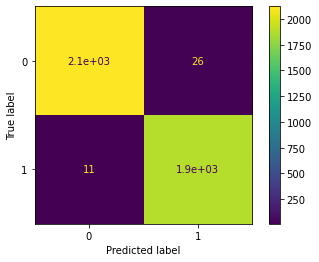

In [22]:
# Performance Metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
plot_confusion_matrix(lr, X_test_1, y_test_1)

In [23]:
test_preds = lr.predict(X_test_1)
print(classification_report(test_preds, y_test_1))
accuracy_score(y_test_1,test_preds)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2133
           1       0.99      0.99      0.99      1915

    accuracy                           0.99      4048
   macro avg       0.99      0.99      0.99      4048
weighted avg       0.99      0.99      0.99      4048



0.9908596837944664

## Unsupervised Learning

We will use **K-Means clustering** to train these dataset
